# Fashion MNIST Bayesian

What it means and what you can do about it!

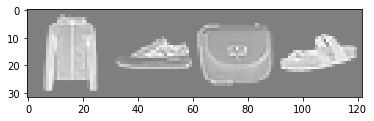

 Coat Sneaker   Bag Sandal


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from blitz.modules import BayesianLinear, BayesianConv2d
from blitz.losses import kl_divergence_from_nn
from blitz.utils import variational_estimator

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True,
                                             transform=transforms.Compose([transforms.ToTensor()]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True,
                                            transform=transforms.Compose([transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Initialize tensorboard
writer = SummaryWriter('runs/fashion_mnist')


# get some random training images
dataiter = iter(trainloader)
testImages, testLabels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(testImages))
# print labels
print(' '.join('%5s' % classes[testLabels[j]] for j in range(4)))

# 2. Define a convolutional neural network


In [2]:
@variational_estimator
class BayesianCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = BayesianConv2d(1, 6, (5,5)) # 6 filters, size 5x5,            output size = 24x24
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = BayesianConv2d(6,16, (3,3)) # 16 filters, size 3x3,           outSize = 10x10

        # Define function
        self.fc1 = BayesianLinear(16*5*5, 160)
        self.fc2 = BayesianLinear(160, 120)
        self.fc3 = BayesianLinear(120, 84)
        self.fc4 = BayesianLinear(84, 10)

    def forward(self, x):
        # First convolution and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def evaluate_classifier(classifier, inputs, samples=10, std_multiplier=2):
    mean, std = classifier.mfvi_forward(inputs, samples)

    return mean, std




# 3. Define a Loss function and optimizer and train the network

In [9]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = BayesianCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
plot_step = 0

for epoch in range (2):
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = classifier.sample_elbo(inputs=inputs.to(device),
        labels=labels.to(device),
        criterion=criterion,
        sample_nbr=3,
        complexity_cost_weight = 1/50000)

        loss.backward()
        optimizer.step()

        if i % 1000 == 0:
            # Add data to tensorboard
            writer.add_scalar("Loss/train", loss, plot_step)

            #preds, means, stds = evaluate_classifier(classifier, testImages, testLabels)

            #print(means)

            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = classifier(images.to(device))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels.to(device)).sum().item()
            print('[%d, %5d] loss: %.3f' % (epoch, i, loss))
            print("The accuracy is: {} %".format(str(100* correct / total)))
            plot_step = plot_step + 1

print('Finished training')
writer.flush()

# Save data
PATH = './model/trained_koen_bay.pth'
torch.save(classifier.state_dict(), PATH)



[0,     0] loss: 11.222
The accuracy is: 10.0 %
[0,  1000] loss: 9.198
The accuracy is: 73.47 %
[0,  2000] loss: 7.396
The accuracy is: 76.97 %
[0,  3000] loss: 7.066
The accuracy is: 78.58 %
[0,  4000] loss: 7.260
The accuracy is: 78.86 %
[0,  5000] loss: 5.097
The accuracy is: 78.83 %
[0,  6000] loss: 4.628
The accuracy is: 79.65 %
[0,  7000] loss: 4.922
The accuracy is: 82.49 %
[0,  8000] loss: 3.487
The accuracy is: 82.73 %


KeyboardInterrupt: 

# 4. Test the network

ONE OUTPUT
tensor([[-3.6837, -3.5927, -2.5350, -3.9797, -4.2509,  2.6424, -2.4252,  1.4292,
         -2.5144,  7.0875],
        [-0.8598, -6.1144,  8.3285, -3.1799,  0.8843, -5.9954,  1.4155, -6.6778,
         -4.3638, -4.2566],
        [-1.5203,  8.2249, -1.7604,  0.9802,  0.0374, -3.6055, -0.1236, -4.9866,
         -2.4712, -5.6948],
        [-1.8253,  5.1077, -1.6065,  1.9061,  1.7429, -4.3672, -0.0858, -4.7473,
         -1.9330, -5.8069]], grad_fn=<AddmmBackward>)
MEAN:
tensor([[-3.4169, -3.4407, -2.2179, -3.6713, -4.2889,  2.7923, -2.5056,  1.2942,
         -2.7123,  6.8118],
        [-0.8746, -5.8627,  8.1155, -2.8387,  1.0160, -5.8624,  1.2154, -7.0833,
         -4.1781, -4.4004],
        [-1.1917,  8.7598, -1.5080,  0.2780, -0.4766, -3.8423, -0.2732, -5.3000,
         -2.5659, -5.4304],
        [-1.5364,  5.9222, -1.4249,  1.3785,  1.1339, -4.4479, -0.2964, -4.8783,
         -1.9390, -5.6204]], grad_fn=<MeanBackward1>)
STANDARD DEVIATION:
tensor([[0.1744, 0.3290, 0.2183, 0.3056

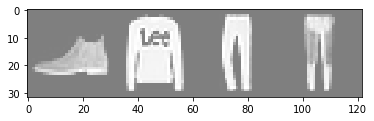

In [6]:
PATH = './model/trained_koen_bay.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataiter = iter(testloader)
images, labels = dataiter.next()

# load the trained model
classifier = BayesianCNN()
classifier.load_state_dict(torch.load(PATH))

outputs = classifier(images.to(device))

mean, std = classifier.mfvi_forward(images)

#print(pred)
print("ONE OUTPUT")
print(outputs)
print("MEAN:")
print(mean)
print("STANDARD DEVIATION:")
print(std)

# pints images
imshow(torchvision.utils.make_grid(images))
print('Ground truth: ', ' '.join('%5f' % labels[j] for j in range(4)))

correct = 0
total = 0
total_false_std = torch.zeros(10)
total_true_std = torch.zeros(10)
true_amount = torch.zeros(10)
false_amount = torch.zeros(10)
with torch.no_grad():
    for data in testloader:
        # stop if too long busy
        if total >= 1000:
            break

        images, labels = data
        mean, std = classifier.mfvi_forward(images.to(device), 30)
        _, predicted = torch.max(mean, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        # divide true from false indices
        for i in range(4):
            if predicted[i] == labels[i]:
                k = labels[i].item()
                total_true_std[k] = total_true_std[k] + std[i,k]
                true_amount[k] = true_amount[k] + 1
            else:
                k = labels[i].item()
                total_false_std[k] = total_false_std[k] + std[i,k]
                false_amount[k] = false_amount[k] + 1

mean_yes_std = total_true_std / true_amount
mean_not_std = total_false_std / false_amount,
print("The accuracy is: {} %".format(str(100* correct / total)))
print(mean_yes_std)
print(mean_not_std)


# 4. Create tensorboard


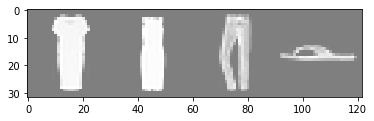

In [55]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)

imshow(img_grid)

writer.add_image('four_fashion_mnist_images', img_grid)
writer.add_graph(net, images)
writer.close()

